- KMeans : 거리기반 군집화
  - 집단 개수를 직접 정해줌
- DBSCAN : 밀도기반 군집화
  - 집단 개수를 정하지 않음
  - 연산 속도가 느림
  - DBSCAN은 StandardSacler가 필수적임, MinMaxScaler도 사용 불가
  - Label -1 : 속한 집단이 없다고 해석
    - 해당 데이터가 잡음(노이즈)로 분류되었음을 의미 : 이상치로 해석
      - 해법 : 이상치 정제, eps와 minPts 파라미터를 튜닝하여 조정
      - 노이즈를 줄여가는 것을 목표로 해야 함

In [1]:
from hossam.util import *
from hossam.plot import *
from hossam.analysis import *

In [2]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors # KNN 생성, eps 파라미터와 관련 있음
import pandas as pd

In [3]:
origin1 = pd.read_excel("./data/game_usage.xlsx")

In [4]:
df1 = my_standard_scaler(origin1)
df1.head()

,time spent,game level
0,-0.250733,1.474805
1,0.326494,0.606546
2,-0.611500,0.795456
3,0.470801,1.674613
4,-1.405187,-1.558652


In [5]:
# min_samples : 독립변수 개수보다 크게 설정하는 것이 좋음
# metric : 콜백함수도 설정 가능
dbs = DBSCAN(eps = 0.5, min_samples = 5, metric = 'euclidean', algorithm = 'kd_tree', leaf_size = 30, n_jobs = -1)
dbs.fit(df1)
cluster = dbs.labels_
cluster

array([ 0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  0, -1,  1,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1, -1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,
        0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  1,  0,  1,  0,  0,  0,  0,
        0,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0],
      dtype=int64)

In [6]:
df1_2 = df1.copy()
df1_2['cluster'] = cluster
df1_2

,time spent,game level,cluster
0,-0.250733,1.474805,0
1,0.326494,0.606546,0
2,-0.611500,0.795456,0
3,0.470801,1.674613,0
4,-1.405187,-1.558652,1
...,...,...,...
95,0.037881,1.456640,0
96,0.146111,-0.192688,0
97,-1.188727,1.373084,0
98,1.192335,-1.100909,0


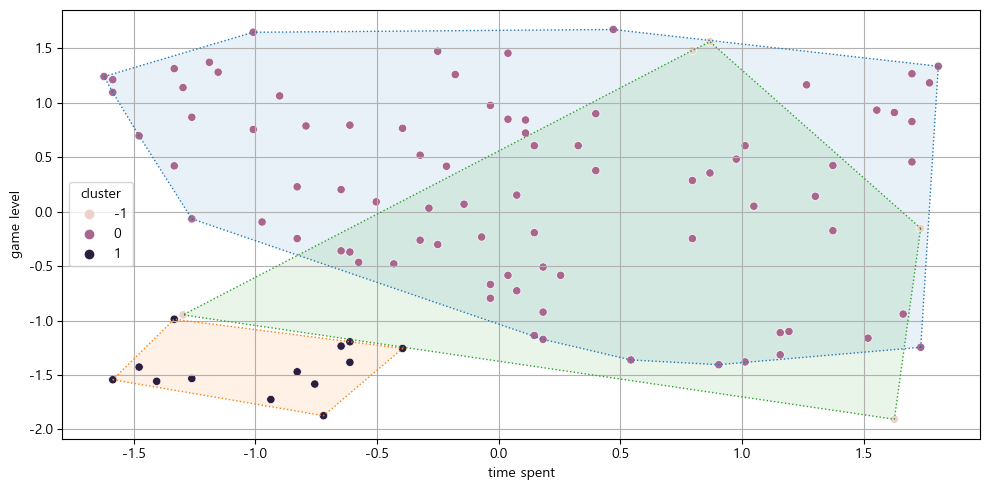

In [7]:
my_convex_hull(df1_2, xname = 'time spent', yname = 'game level', hue = 'cluster')

- eps값을 선택하기 : KNN을 이용
  - 데이터의 밀도 변화를 시각화하여 Elbow Method 사용

In [8]:
k = 5

neighbors = NearestNeighbors(n_neighbors = k)
neighbors.fit(df1)

# 한 점의 최근접 이웃
distance, indices = neighbors.kneighbors(df1)

In [9]:
distance[:5]

array([[0.        , 0.22615872, 0.28918464, 0.54273855, 0.68828954],
       [0.        , 0.1803835 , 0.23997564, 0.24570226, 0.30298035],
       [0.        , 0.18052977, 0.21840257, 0.39442254, 0.39885068],
       [0.        , 0.37748709, 0.41251429, 0.48469813, 0.7486887 ],
       [0.        , 0.14653036, 0.14936701, 0.18096788, 0.49788041]])

In [10]:
s_distance = np.sort(distance, axis = 0)
s_distance[:5]

array([[0.        , 0.03768698, 0.10111015, 0.12715087, 0.2164602 ],
       [0.        , 0.03768698, 0.11039822, 0.14503661, 0.22405052],
       [0.        , 0.03768698, 0.11625223, 0.14619664, 0.23887731],
       [0.        , 0.03768698, 0.11988511, 0.14619664, 0.24570226],
       [0.        , 0.04632699, 0.12172144, 0.14620339, 0.24647088]])

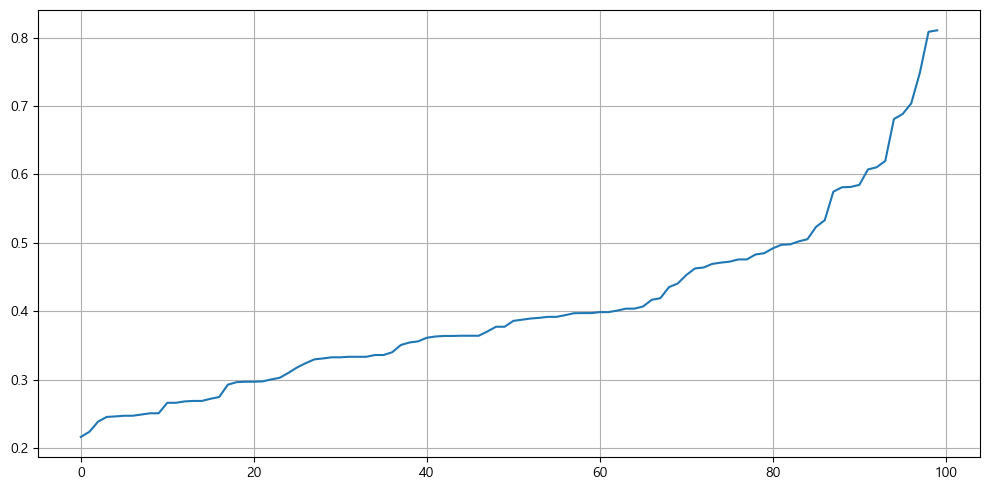

In [11]:
target = s_distance[:, k-1]
my_lineplot(df = None, xname = range(0, len(target)), yname = target)

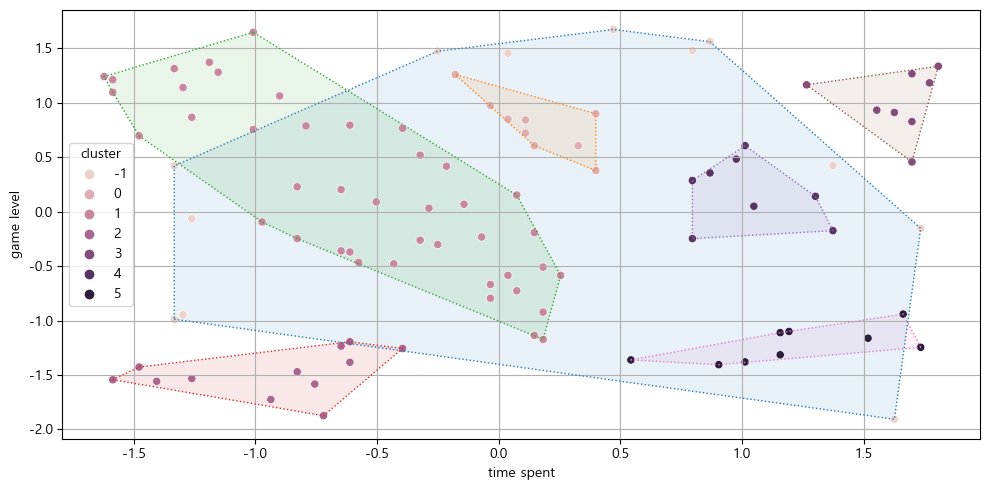

In [12]:
dbs = DBSCAN(eps = 0.4, min_samples = 5, metric = 'euclidean', algorithm = 'kd_tree', leaf_size = 30, n_jobs = -1)
dbs.fit(df1)

df1_3 = df1.copy()
df1_3['cluster'] = dbs.labels_

my_convex_hull(df1_3, xname = 'time spent', yname = 'game level', hue = 'cluster')

- KNN의 k 값을 바꿔가며 적합한 epsilon 값을 찾아야 함
  - min_samples를 k로 설정
  - 인접 k개의 거리 중 가장 먼 거리를 측정하여 eps 값을 튜닝

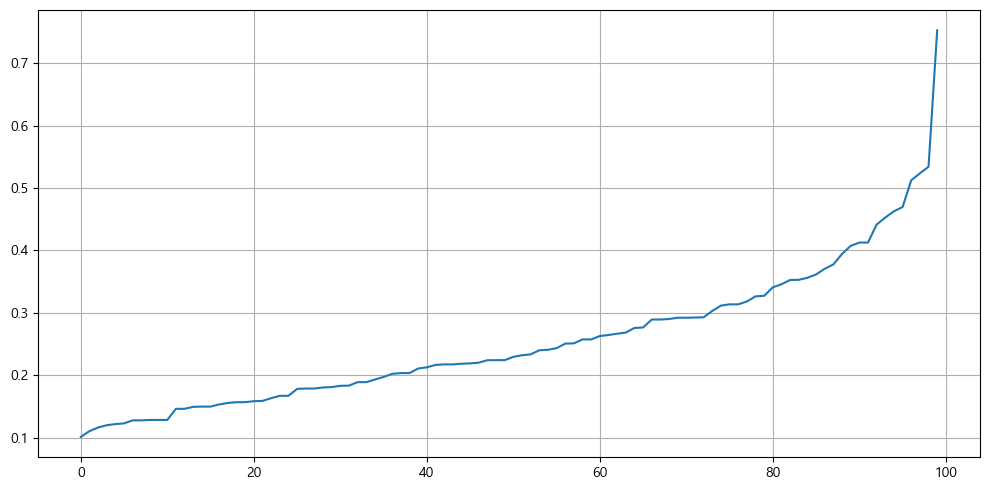

In [13]:
k = 3

neighbors = NearestNeighbors(n_neighbors = k)
neighbors.fit(df1)
distance, indices = neighbors.kneighbors(df1)
s_distance = np.sort(distance, axis = 0)
target = s_distance[:, k-1]
my_lineplot(df = None, xname = range(0, len(target)), yname = target)

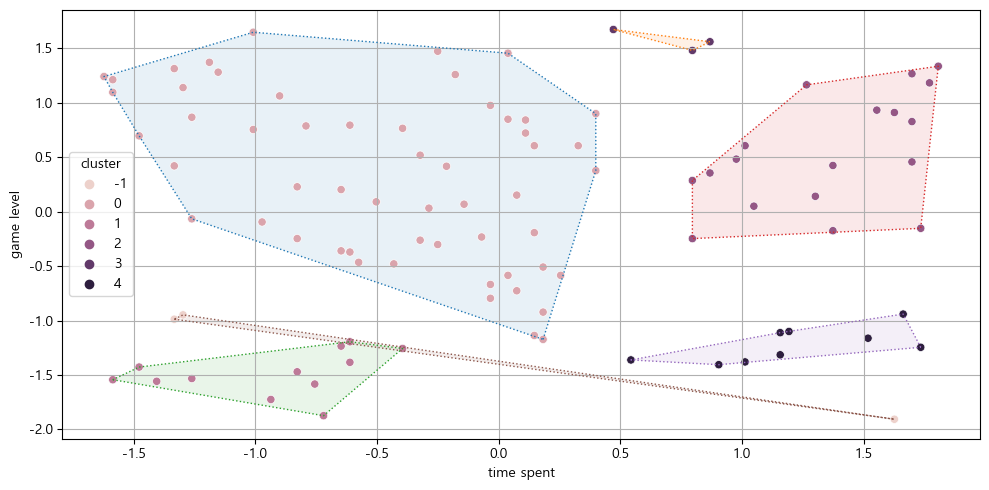

In [14]:
dbs = DBSCAN(eps = 0.4, min_samples = k, metric = 'euclidean', algorithm = 'kd_tree', leaf_size = 30, n_jobs = -1)
dbs.fit(df1)

df1_3 = df1.copy()
df1_3['cluster'] = dbs.labels_

my_convex_hull(df1_3, xname = 'time spent', yname = 'game level', hue = 'cluster')

In [15]:
change_rates = [0]
for i in range(1, len(target)):
    change_rate = (target[i] - target[i-1]) / target[i-1]
    change_rates.append(change_rate)

avg_change_rate = np.mean(change_rates)

elbow_point = next((i for i, rate in enumerate(change_rates) if rate > avg_change_rate), None)

target[elbow_point]

0.11039821824499696